This notebook demonstartes how to access and query *CORD-19 Named Entities Knowledge Graph (CORD19-NEKG)* RDF dataset [1]. The dataset describes named entities identified in the scholarly articles of the [COVID-19 Open Research Dataset (CORD-19)](https://pages.semanticscholar.org/coronavirus-research) [2], a resource of over 47,000 articles about COVID-19 and the coronavirus family of viruses.

#### __References__
[1] COVID-19 Open Research Dataset (CORD-19). 2020. Version 2020-04-03. Retrieved from https://pages.semanticscholar.org/coronavirus-research. Accessed 2020-04-06. doi:10.5281/zenodo.3715505

[2] F. Michel, L. Djimenou, C. Faron-Zucker, and J. Montagnat. Translation of Relational and Non-Relational Databases into RDF with xR2RML. In Proceedings of the 11th International Confenrence on Web Information Systems and Technologies (WEBIST 2015), Lisbon, Portugal, 2015.


#### __Cite this work__
When including CORD19-NEKG data in a publication or redistribution, please cite the dataset as follows:

R. Gazzotti, F. Michel, F. Gandon. CORD-19 Named Entities Knowledge Graph (CORD19-NEKG). University Côte d'Azur, Inria, CNRS. 2020. Retrieved from https://github.com/Wimmics/cord19-nekg.


In [2]:
R.Version()$version

[1] "R version 3.6.1 (2019-07-05)"

In [3]:
install.packages("SPARQL")

package 'SPARQL' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\abobashe\AppData\Local\Temp\RtmpeMKSeE\downloaded_packages


In [5]:
options(warn=-1)

library(SPARQL)

### Define dataset endpoint for the SPARQL data access. 

In [6]:
endpoint <- "https://covid19.i3s.unice.fr/sparql"
options <- NULL

### Define prefixes to abbreviare namespaces. 
The first set of prefixes is used in the SPARQL query and the second to abbreviate the returned data.

In [7]:
sparql_prefix <- '
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl:    <http://www.w3.org/2002/07/owl#>
PREFIX xsd:    <http://www.w3.org/2001/XMLSchema#>

PREFIX bibo:   <http://purl.org/ontology/bibo/> 
PREFIX dce:    <http://purl.org/dc/elements/1.1/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX foaf:   <http://xmlns.com/foaf/0.1/>
PREFIX frbr:   <http://purl.org/vocab/frbr/core#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX prov:   <http://www.w3.org/ns/prov#>
PREFIX schema: <http://schema.org/>

prefix wd:     <http://www.wikidata.org/entity/>
prefix wdt:    <http://www.wikidata.org/prop/direct/>

PREFIX covid:   <http://ns.inria.fr/covid19/>
PREFIX covidpr: <http://ns.inria.fr/covid19/property/>
'

data_prefix <- c('covid','<http://ns.inria.fr/covid19/>', 
                'wd',   '<http://www.wikidata.org/entity/>',
                'wdt',  '<http://www.wikidata.org/prop/direct/>')

### Working with article metadata
Query dataset for the articles that mention the term *coronavirus* in their abstracts. 

In [8]:
query <- '
SELECT (group_concat(distinct ?name,"; ") AS ?authors)
       ?title 
       (year(?date) as ?year)
       ?pub
       ?url

WHERE {
    graph <http://ns.inria.fr/covid19/graph/articles>
    {
        ?doc a ?t;
            dce:creator ?name;
            dct:title ?title;
            schema:publication ?pub;
            schema:url ?url;
            dct:abstract [ rdf:value ?abs ].

        optional { ?doc dct:issued ?date }
        filter contains(?abs, "coronavirus")
    }
} 
group by ?doc ?title ?date ?pub ?url
order by desc(?date)

'

query <- paste(sparql_prefix, query)

res <- SPARQL(url= endpoint,
              query = query,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(res)))

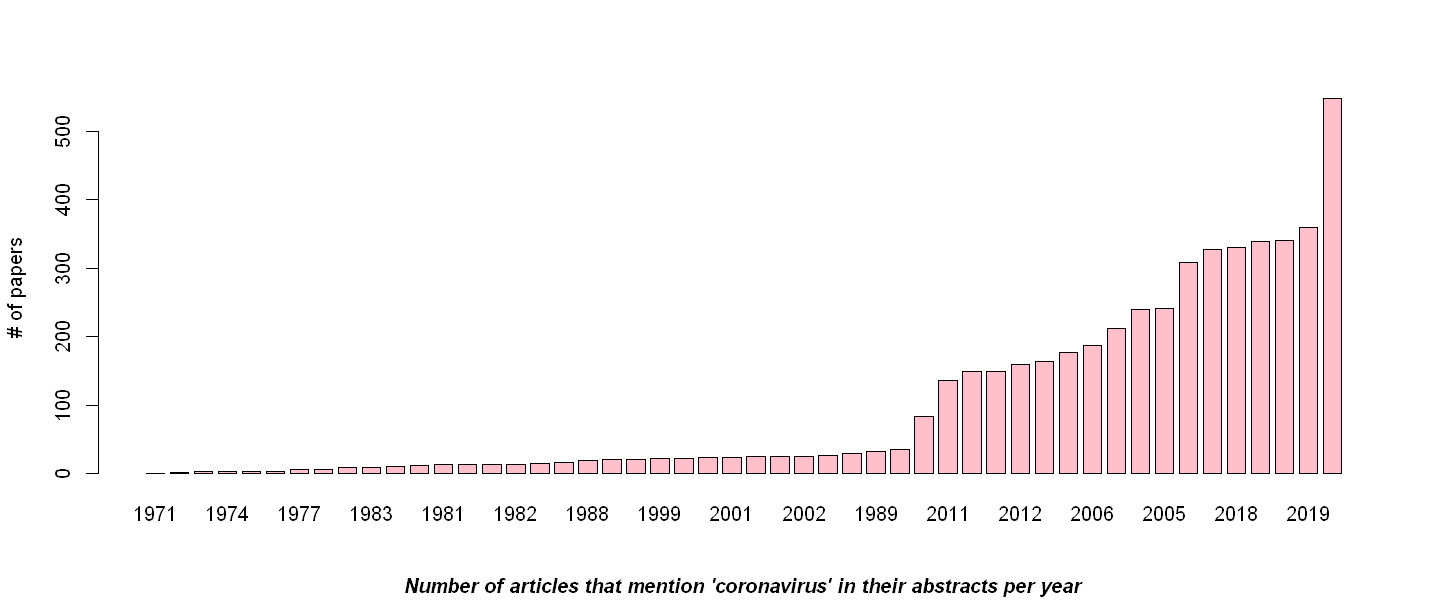

In [64]:
options(repr.plot.width = 12)
options(repr.plot.height = 5)
options(repr.plot.align = 'center')

barplot(sort(table(res$year)),
        col="pink",
        space=0.3,
        ylab="# of papers",
        sub="Number of articles that mention 'coronavirus' in their abstracts per year",
        font.sub=4)


### Working with article annotations
Query dataset for the articles refrencing *coronavirus* and forms of *cancer* at the same time

In [11]:
query_corona_vs_cancer = '
# wdt:P279 = subclass of 
# wdt:P31 = instance of
# wd:Q12078 = cancer
# wd:Q1134583 = coronavirus family

select distinct ?article ?dis1 ?dis1Label ?dis2 ?dis2Label #?dis2Subject

from <http://ns.inria.fr/covid19/graph/entityfishing>
from named <http://ns.inria.fr/covid19/graph/wikidata-named-entities>

where {
    # Look for 2 annotations of the same article with Wikidata URIs ?dis1 and ?dis2 

    ?annot1 schema:about ?article; oa:hasBody ?dis1.
    ?annot2 schema:about ?article; oa:hasBody ?dis2.
 
    graph <http://ns.inria.fr/covid19/graph/wikidata-named-entities>
    {
      ?entity1 rdfs:label "cancer"@en. # ?entity1 is wd:Q12078
      
      { ?dis1 rdfs:label ?dis1Label.
        filter (?dis1 = ?entity1) } # ?dis1 is "cancer"

      UNION

      { ?dis1 wdt:P279 ?entity1;
              rdfs:label ?dis1Label. }  # ?dis1 is a subclass of "cancer" (at any depth)

      UNION

      { ?dis1 wdt:P31 ?entity1; 
              rdfs:label ?dis1Label. }  # ?dis1 is an instance of "cancer" or a subclass



      ?entity2 rdfs:label "Coronaviridae"@en. # ?entity2 is wd:Q1134583

      { ?dis2 rdfs:label ?dis2Label. 
      filter (?dis2 = ?entity2) }

      UNION

      { ?dis2 wdt:P279 ?entity2;
              rdfs:label ?dis2Label. } # ?dis2 is a subclass of "Coronaviridae" (at any depth)

      UNION

      { ?dis2 wdt:P31 ?entity2; 
              rdfs:label ?dis2Label. }  # ?dis2 is an instance of "Coronaviridae" or a subclass

    }

    
}
order by ?dis1 ?dis2
limit 1000
'

query_corona_vs_cancer <- paste(sparql_prefix, query_corona_vs_cancer)

res <- SPARQL(url= endpoint,
              query = query_corona_vs_cancer,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(res)))

[1] 153

In [70]:
# remove label decorations
res <- data.frame(lapply(res, function(x) {
                  gsub("@en", "", x)
              }))
res <- data.frame(lapply(res, function(x) {
                  gsub("\"", "", x)
              }))

In [44]:
res

article,dis1,dis1Label,dis2,dis2Label,group
covid:732a0d11a565368fd2cb50736fe09c34d5beae25,wd:Q1088156,"""chronic lymphocytic leukemia""@en",wd:Q6926073,"""Mouse hepatitis virus""@en",3
covid:5752da49269229713484d3f3b72ea2cac18b218c,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q16532287,"""Betacoronavirus""@en",1
covid:3dd399d305426e614eae51dd03fb48fa86c4d324,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q16983356,"""Human coronavirus 229E""@en",2
covid:5752da49269229713484d3f3b72ea2cac18b218c,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q16983356,"""Human coronavirus 229E""@en",2
covid:5752da49269229713484d3f3b72ea2cac18b218c,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q16991954,"""Human coronavirus OC43""@en",2
covid:7b620ef79c42118f157be2d9ab586fbd615b9fc6,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q278567,"""severe acute respiratory syndrome-related coronavirus""@en",2
covid:c6a72d0b6a1510ac7ecb3e16179d9784990f6314,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q278567,"""severe acute respiratory syndrome-related coronavirus""@en",2
covid:3dd399d305426e614eae51dd03fb48fa86c4d324,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q290805,"""Coronavirus""@en",1
covid:c1e82ab3646382fd09d4e38c7041f89466f5028d,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q290805,"""Coronavirus""@en",1
covid:ddba9808c2e5a41e0a27996ff5b59e4c09ae159a,wd:Q1148337,"""hepatocellular carcinoma""@en",wd:Q290805,"""Coronavirus""@en",1


In [48]:
res$dis2[grep('Trans', res$dis2Label )]

[1] "wd:Q7834605" "wd:Q7834605" "wd:Q7834605" "wd:Q7834605" "wd:Q7834605"
 [6] "wd:Q7834605" "wd:Q7834605" "wd:Q7834605" "wd:Q7834605" "wd:Q7834605"

### Visualize query results in different ways
Plot hierarchically-clustered heatmap

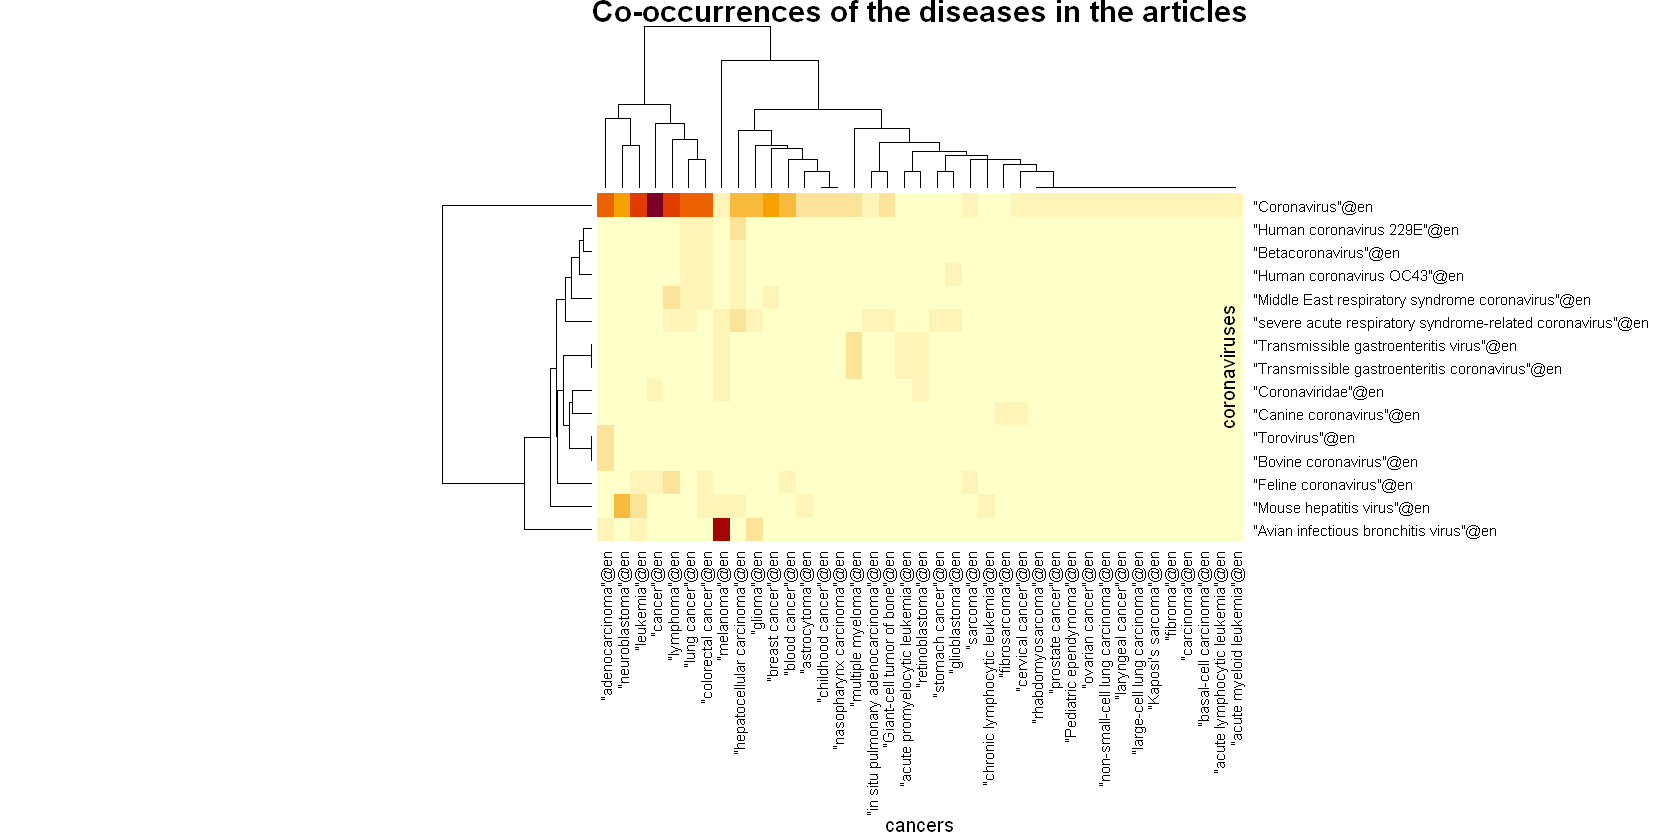

In [29]:
options(repr.plot.width = 14)
options(repr.plot.height = 7)
options(repr.plot.align = 'left')

hm <- table(res[, c('dis2Label','dis1Label')])
hm <- as.matrix(hm)

heatmap(hm,  margins = c(15,0), #Rowv = NA, Colv = NA,
        col = hcl.colors(12, "YlOrRd", rev = TRUE), 
        scale="none", 
        cexCol=0.9,
        cexRow = 0.9,
        main="Co-occurrences of the diseases in the articles",
        xlab="cancers", 
        ylab="coronaviruses")

Plot heatmap with ggplot

In [30]:
options(warn=-1)

library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


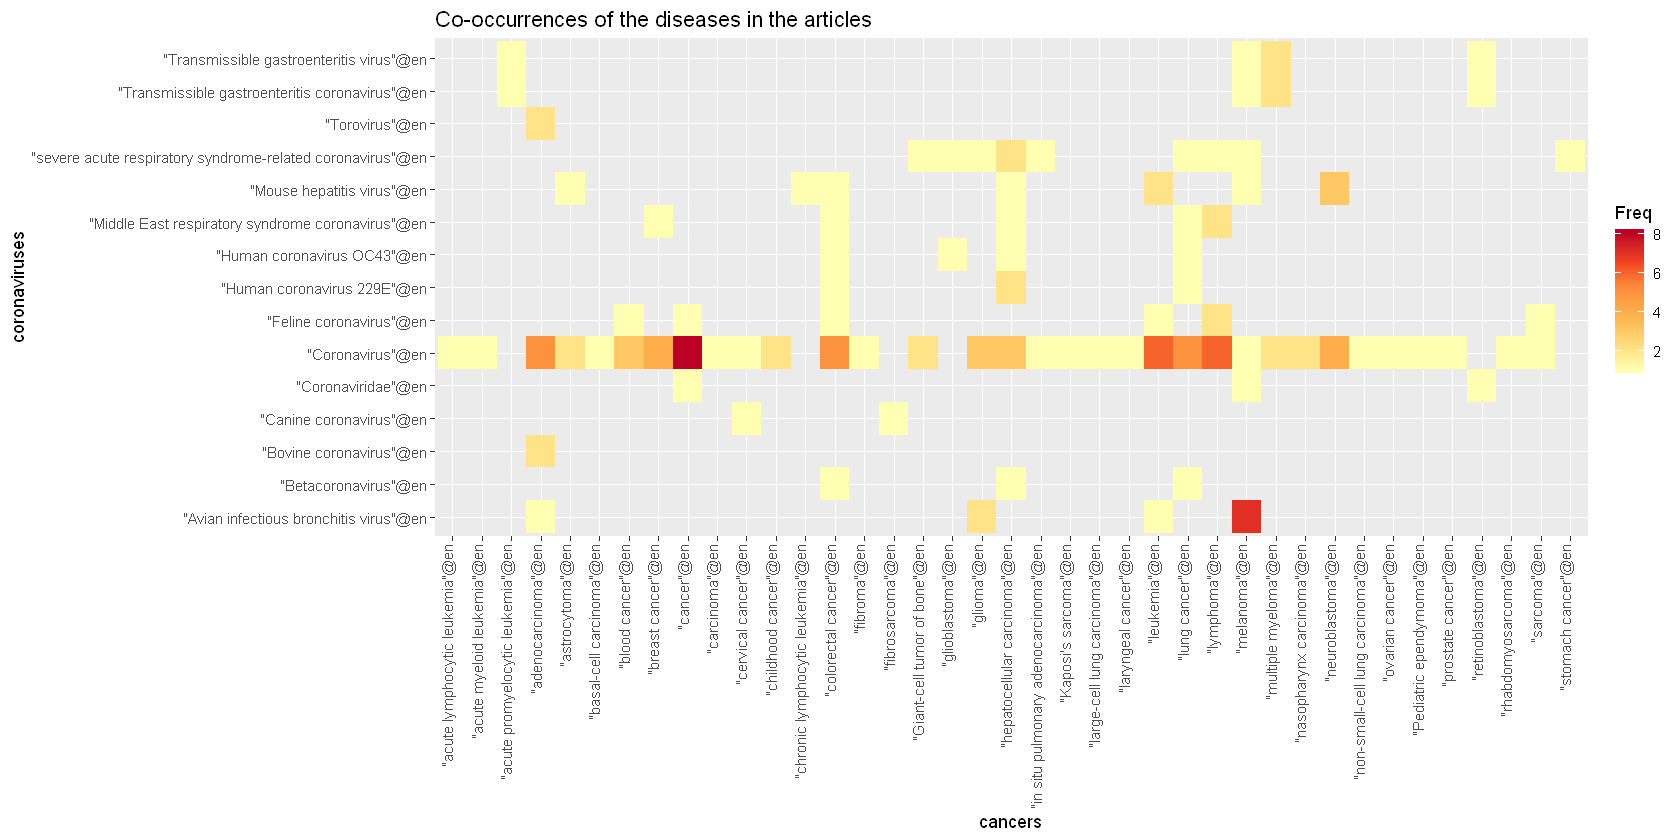

In [31]:
counts <- table(res[, c('dis2Label','dis1Label')])
counts <- as.data.frame(counts)
counts <- counts[counts$Freq > 0, ]

ggplot(counts, aes(x=dis1Label, y=dis2Label, fill=Freq)) + 
       geom_tile() +
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
       scale_fill_distiller(palette = "YlOrRd", direction = 1) +
       ggtitle("Co-occurrences of the diseases in the articles") +
       xlab("cancers") + 
       ylab("coronaviruses")

Plot bubble chart

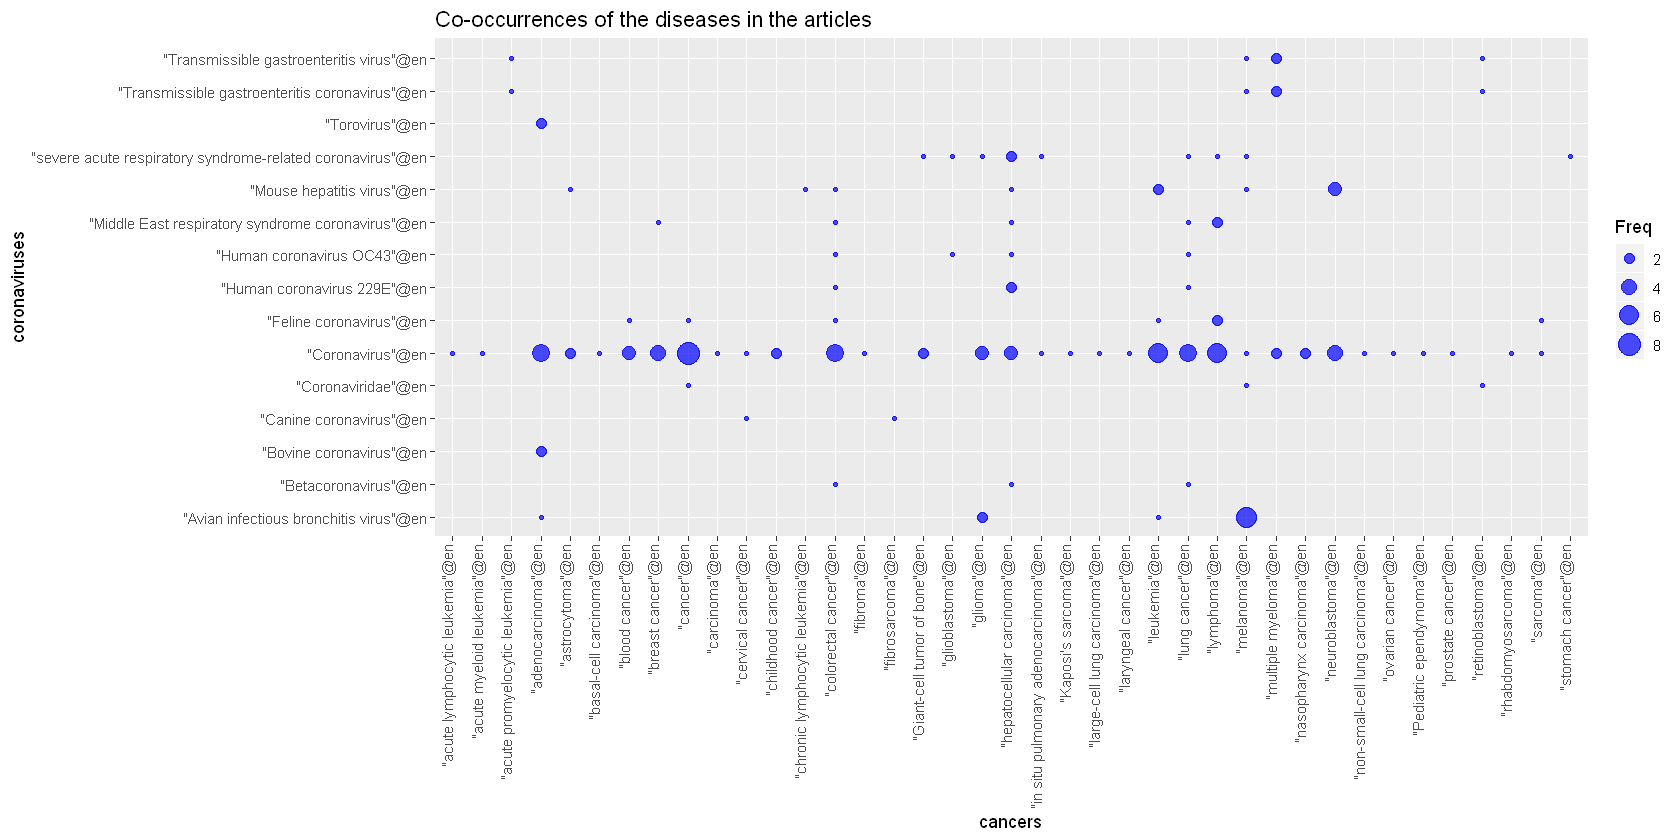

In [35]:
# Most basic bubble plot
ggplot(counts, aes(x=dis1Label, y=dis2Label, size = Freq)) +
       geom_point(alpha=0.7, color='blue') +
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
       ggtitle("Co-occurrences of the diseases in the articles") +
       xlab("cancers") + 
       ylab("coronaviruses") 

Plot stacked bar chart with default colors

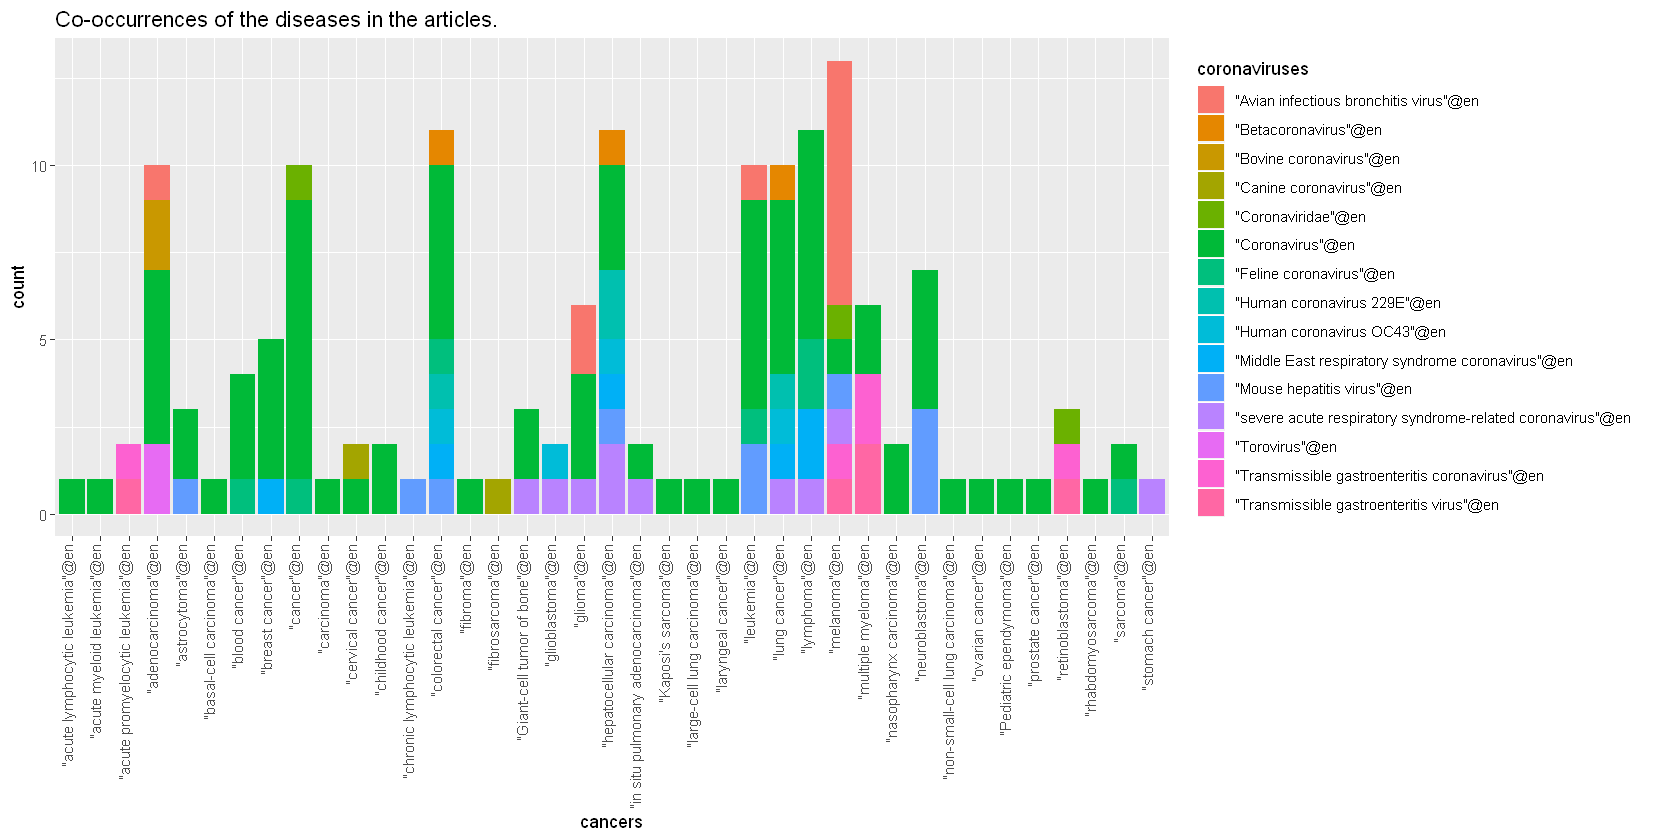

In [36]:
ggplot(res, 
       aes(x = dis1Label, 
           fill = dis2Label)) + 
  geom_bar(position = "stack") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
  ggtitle("Co-occurrences of the diseases in the articles.") +
  xlab("cancers") + 
  ylab("count") +
  labs(fill = "coronaviruses")

Plot stacked bar chart with default colors

In [107]:
# use RColorBrewer for custom coloring
library(RColorBrewer)

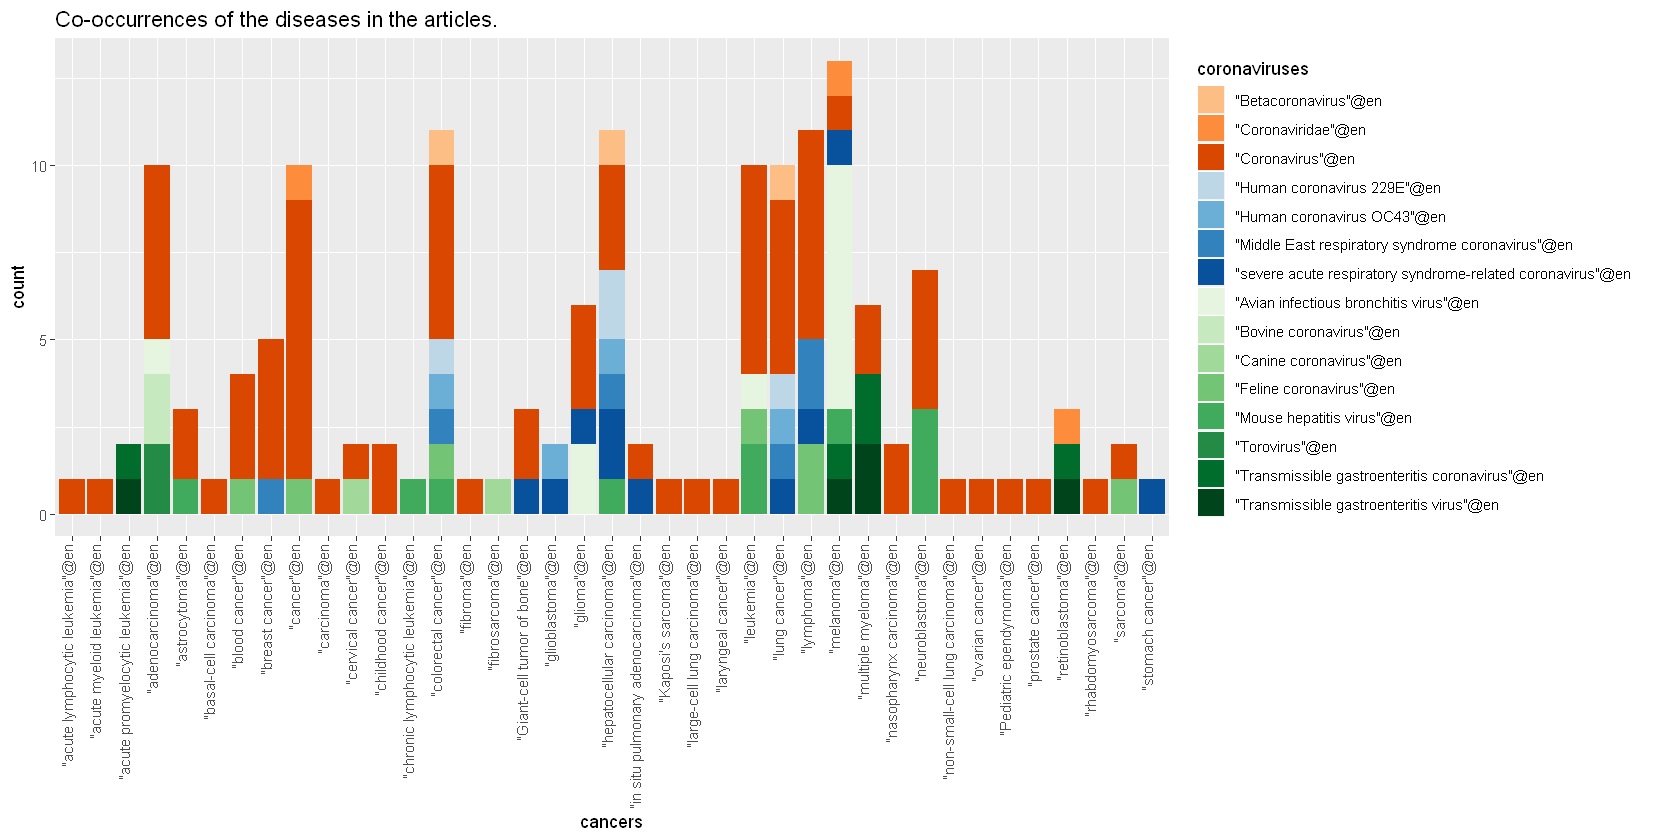

In [124]:
# Manually group coronaviruses in 3 groups (general(1), human(2), animal(3)) for reordering
res$group <- rep(3, nrow(res))
res$group[grep('Human', res$dis2Label )] <- 2
res$group[grep('Corona', res$dis2Label )] <- 1
res$group[grep('Beta', res$dis2Label )] <- 1
res$group[grep('severe acute', res$dis2Label )] <- 2
res$group[grep('Middle', res$dis2Label )] <- 2


# Manually choose colors for coronaviruses (shades of purple for general (1), blues for humans(2), and greens for animals(3))
# select one color over and shift the palete to avoid the very light colors

general_colors <- brewer.pal(length(unique(res$dis2Label[res$group == 1])) +1 , 'Oranges')[-1]
names(general_colors) <- sort(unique(res$dis2Label[res$group == 1]))

human_colors <- brewer.pal(length(unique(res$dis2Label[res$group == 2])) +1 , 'Blues')[-1]
names(human_colors) <- sort(unique(res$dis2Label[res$group == 2]))

animal_colors <- brewer.pal(length(unique(res$dis2Label[res$group == 3])) +1 , 'Greens')[-1]
names(animal_colors) <- sort(unique(res$dis2Label[res$group == 3]))

ggplot(res, 
       aes(x = dis1Label, fill = reorder(dis2Label , group))) + 
      geom_bar(position = "stack") +
      theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
      scale_fill_manual(name = "coronaviruses", values = c(general_colors, human_colors, animal_colors)) +
      ggtitle("Co-occurrences of the diseases in the articles.") +
      xlab("cancers") + 
      ylab("count") +
      labs(fill = "coronaviruses")

Plot barplot for grouped diseases

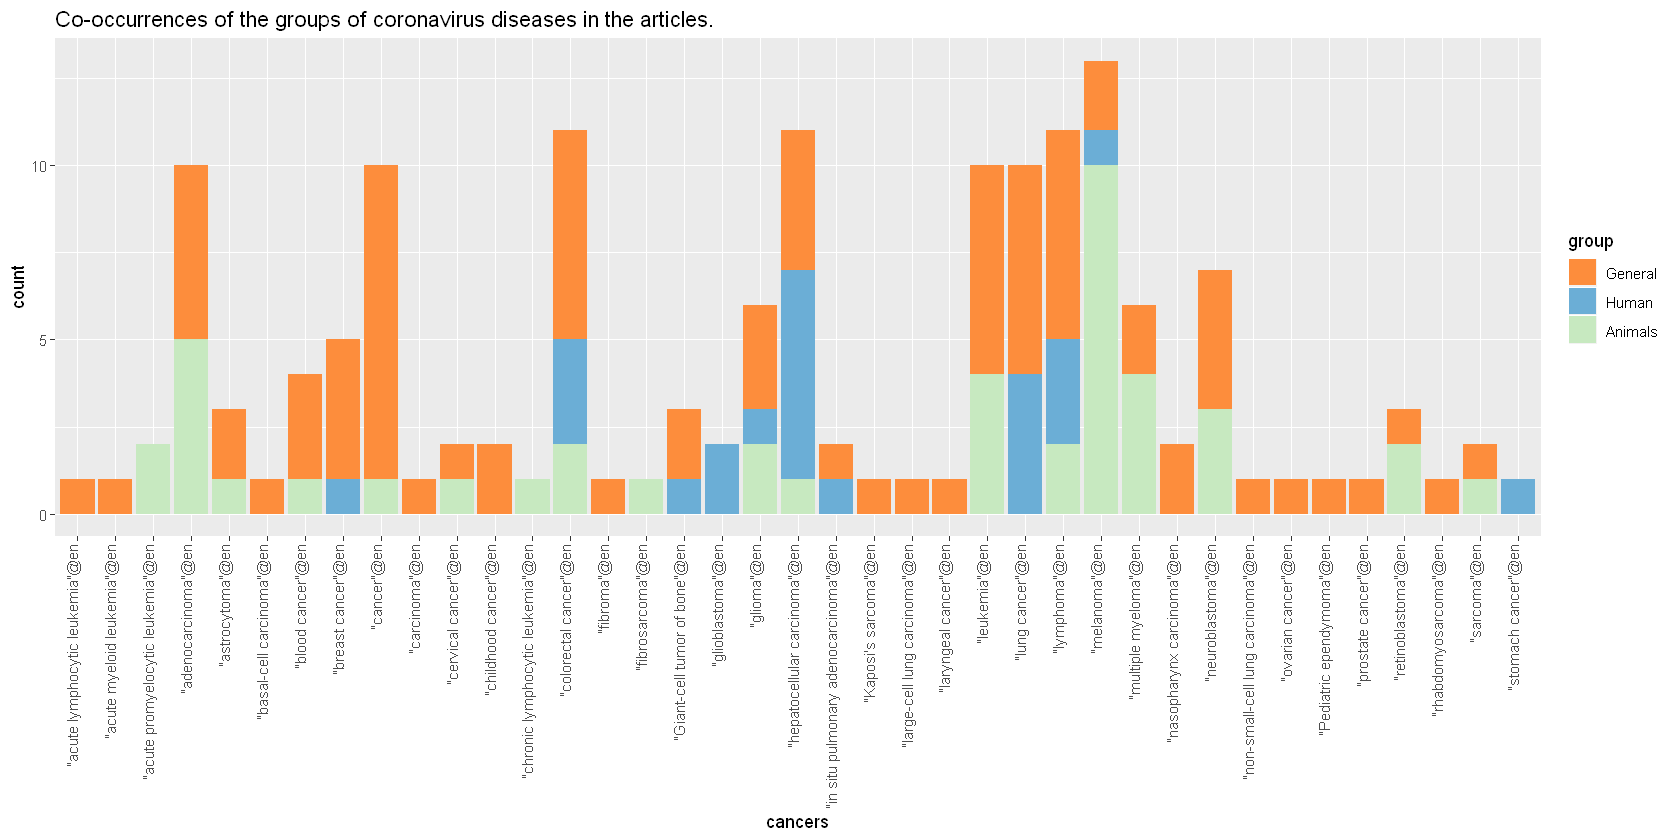

In [126]:
#group_colors = c('plum', 'skyblue', ' green')
group_colors = c (general_colors[2], human_colors[2], animal_colors[2])
names(group_colors) <- c("General", "Human", "Animals")
                 
ggplot(res, 
       aes(x = dis1Label, 
           fill =  factor(group, levels = c(1, 2, 3), labels = c("General", "Human", "Animals")))) + 
  geom_bar(position = "stack") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
  scale_fill_manual(name = "group", values = group_colors) +
  ggtitle("Co-occurrences of the groups of coronavirus diseases in the articles.") +
  xlab("cancers") + 
  ylab("count") +
  labs(fill = "coronaviruses")

Query dataset for the articles refrencing coronavirus and specific vaccines

In [128]:
query_vaccines = '
# wdt:P279 = subclass of 
# wdt:P31 = instance of
# wd:Q12078 = cancer
# wd:Q1134583 = coronavirus family

select distinct ?article ?dis1 ?dis1Label ?dis2 ?dis2Label (year(?date) as ?year)

from <http://ns.inria.fr/covid19/graph/entityfishing/body>
from named <http://ns.inria.fr/covid19/graph/wikidata-named-entities>
from named <http://ns.inria.fr/covid19/graph/articles>

where {
    # Look for 2 annotations of the same article with Wikidata URIs ?dis1 and ?dis2 

    ?annot1 schema:about ?article; oa:hasBody ?dis1.
    ?annot2 schema:about ?article; oa:hasBody ?dis2.

    graph <http://ns.inria.fr/covid19/graph/wikidata-named-entities>
    {
      ?entity1 rdfs:label "vaccine"@en. # ?entity1 is wd:Q134808
      
      #{ ?dis1 rdfs:label ?dis1Label.
      #  filter (?dis1 = ?entity1) } # ?dis1 is "vaccine"

      #UNION

      { ?dis1 wdt:P279 ?entity1;
              rdfs:label ?dis1Label. }  # ?dis1 is a subclass of "vaccine" (at any depth)

      UNION

      { ?dis1 wdt:P31 ?entity1; 
              rdfs:label ?dis1Label. }  # ?dis1 is an instance of "vaccine" or a subclass



      ?entity2 rdfs:label "Coronaviridae"@en. # ?entity2 is wd:Q1134583

      { ?dis2 rdfs:label ?dis2Label. 
      filter (?dis2 = ?entity2) }

      UNION

      { ?dis2 wdt:P279 ?entity2;
              rdfs:label ?dis2Label. } # ?dis2 is a subclass of "Coronaviridae" (at any depth)

      UNION

      { ?dis2 wdt:P31 ?entity2; 
              rdfs:label ?dis2Label. }  # ?dis2 is an instance of "Coronaviridae" or a subclass

    }

    graph <http://ns.inria.fr/covid19/graph/articles>
    {
        optional { ?article dct:issued ?date }
        #optional {?article dct:title ?title}
    }
}
order by ?dis1 ?dis2
limit 1000
'

query_vaccines <- paste(sparql_prefix, query_vaccines)

res_vaccine <- SPARQL(url= endpoint,
              query = query_vaccines,
              ns=prefix,
              extra=NULL)$results

Space required after the Public Identifier
SystemLiteral " or ' expected
SYSTEM or PUBLIC, the URI is missing
Entity 'nbsp' not defined


ERROR: Error: 1: Space required after the Public Identifier
2: SystemLiteral " or ' expected
3: SYSTEM or PUBLIC, the URI is missing
4: Entity 'nbsp' not defined



In [228]:
# remove label decorations
res_vaccine <- data.frame(lapply(res_vaccine, function(x) {
                  gsub("@en", "", x)
              }))
res_vaccine <- data.frame(lapply(res_vaccine, function(x) {
                  gsub("\"", "", x)
              }))

In [229]:
nrow(res_vaccine)

[1] 361

In [258]:
data.frame(table(res_vaccine[, c('article', 'dis1Label')]))

article,dis1Label,Freq
covid:008cf2148ee4383534191b3736096878cad82c67,adenovirus vaccine,0
covid:011b8a7002da6c0fae7ca76c127567a6462daf5d,adenovirus vaccine,0
covid:0185df64da339e8d1b822db72fee79a25edeb759,adenovirus vaccine,0
covid:03302abf698fc986829cbbbd9f660abdbf9321e3,adenovirus vaccine,0
covid:072c2b54785898927452a92474f5af84f3fc7ba8,adenovirus vaccine,0
covid:09dd79dc2dd8710c23ef3c713c8245332385d681,adenovirus vaccine,0
covid:0ac431a9a48289831c825c2b30f48bdf7f548995,adenovirus vaccine,0
covid:0ba1801a150e25b029cf3c2a38573435b21dea80,adenovirus vaccine,0
covid:0be19bfb83d9eb0a6b6f1c7ce8b75a58d8b1ed6f,adenovirus vaccine,0
covid:0dbb8e8757f40e57ded9443666880d99a63c8d7e,adenovirus vaccine,0


In [245]:
distinct_articles <- as.data.frame.matrix(table(res_vaccine[, c('article', 'dis2Label')]))

In [247]:
distinct_articles

,Alphacoronavirus,Avian infectious bronchitis virus,Betacoronavirus,Bovine coronavirus,Canine coronavirus,Coronaviridae,Coronavirus,Deltacoronavirus,Feline coronavirus,Gammacoronavirus,Human coronavirus 229E,Human coronavirus OC43,Middle East respiratory syndrome coronavirus,Mouse hepatitis virus,Porcine epidemic diarrhea virus,severe acute respiratory syndrome-related coronavirus,Transmissible gastroenteritis coronavirus,Transmissible gastroenteritis virus,Turkey coronavirus
covid:008cf2148ee4383534191b3736096878cad82c67,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
covid:011b8a7002da6c0fae7ca76c127567a6462daf5d,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
covid:0185df64da339e8d1b822db72fee79a25edeb759,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
covid:03302abf698fc986829cbbbd9f660abdbf9321e3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
covid:072c2b54785898927452a92474f5af84f3fc7ba8,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
covid:09dd79dc2dd8710c23ef3c713c8245332385d681,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
covid:0ac431a9a48289831c825c2b30f48bdf7f548995,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
covid:0ba1801a150e25b029cf3c2a38573435b21dea80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
covid:0be19bfb83d9eb0a6b6f1c7ce8b75a58d8b1ed6f,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
covid:0dbb8e8757f40e57ded9443666880d99a63c8d7e,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [250]:
distinct_articles[distinct_articles$Coronavirus > 0 & ,])

[1] 115

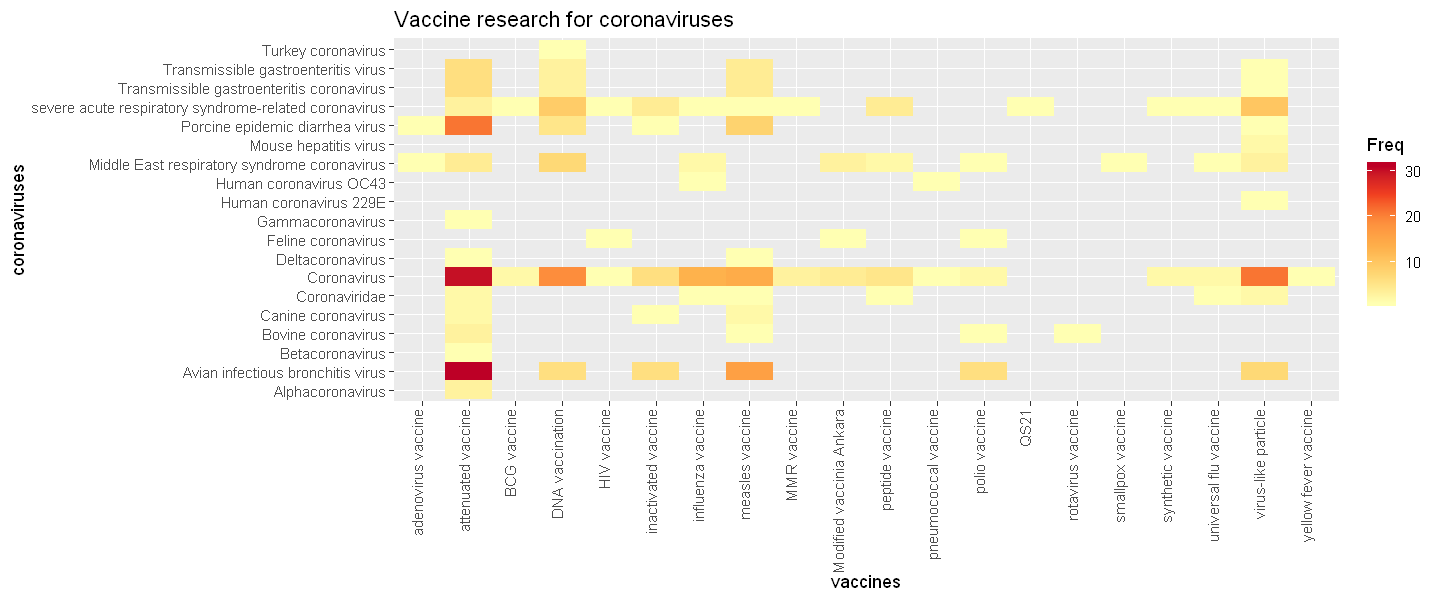

In [254]:
counts <- table(res_vaccine[, c('dis1Label','dis2Label')])
counts <- as.data.frame(counts)
counts <- counts[counts$Freq > 0, ]

ggplot(counts, aes(x=dis1Label, y=dis2Label, fill=Freq)) + 
       geom_tile() +
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
       scale_fill_distiller(palette = "YlOrRd", direction = 1) +
       ggtitle("Vaccine research for coronaviruses") +
       xlab("vaccines") + 
       ylab("coronaviruses")

In [ ]:
res_vaccine$year <- as.numeric(res_vaccine$year) + 1994
res_vaccine_recent <- res_vaccine[res_vaccine$year > 2000,]

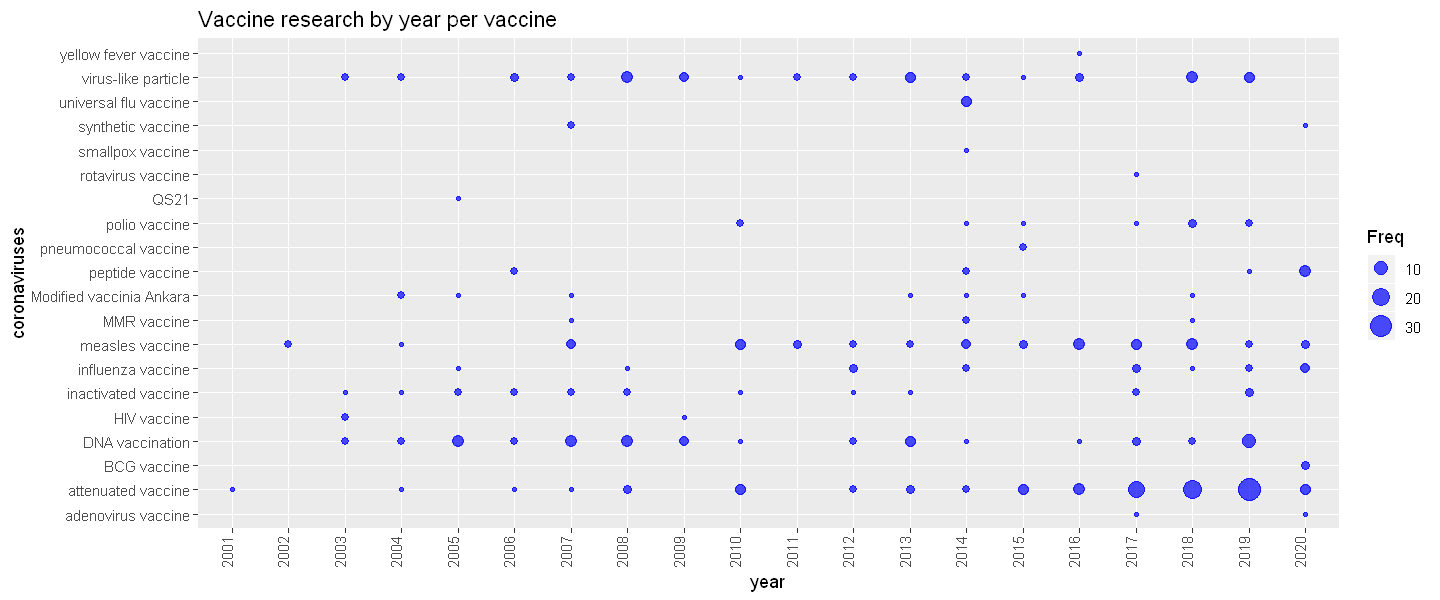

In [255]:
counts <- table(res_vaccine_recent[, c('year','dis1Label')])
counts <- as.data.frame(counts)
counts <- counts[counts$Freq > 0, ]

ggplot(counts, aes(x=year, y=dis1Label, size = Freq)) +
       geom_point(alpha=0.7, color='blue') +
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
       ggtitle("Vaccine research by year per vaccine") +
       xlab("year") + 
       ylab("coronaviruses") 

In [17]:
rainbow(4)

[1] "#FF0000FF" "#80FF00FF" "#00FFFFFF" "#8000FFFF"

In [20]:
Greens(5)

ERROR: Error in Greens(5): could not find function "Greens"
